# <center>Predicting Pokemon Battle Outcomes</center>
### <center>Michael Bailey, Robert Calkins, Matt Falzon</center>

<p align="center">
    <img src="https://github.com/mgfalzon/Final-Tutorial/blob/main/all_pokemons.png?raw=1#center" width="500" height="300">
</P>

### <b>What are Pokémon?</b> <br>

<p>
Pokémon is a video game franchise centered around fictional creatures called 'Pokémon' which humans catch, train, and battle for sport. In the game, the player is tasked with building a team of strong Pokémon which they will use in to challenge other 'Pokemon Trainers'.
</p>

<p>
Each Pokémon has a unique look, typing and a set of base stats. Each Pokemon can be identified by a unique number. The typing follows a rock-paper-scissors like mechanic where, for example, a Pokémon of type water has an advantage over a Pokémon of type fire. The stats determine how much health, strength and speed a Pokémon might have. Since each Pokémon is different it can be hard to tell without experience which would have an edge over another in a battle.
</p>

### <b>Why do we want to predict Pokémon battle outcomes?</b>

<p>
While predicting Pokémon battle outcome might not have a broader implication than anything passed getting better at playing Pokémon, this problem is not unlike many others we see in every day life. Sports players and teams are given a set of stats that are not unlike a set of stats given to a Charzard. If we can train a model to predict the outcome of a battle between two unique Pokémon why would we not be able to extend this to two sports teams or players?
</p>

### <b>How are we going to use Datascience?</b>

<p>
This tutorial seeks to explore the relationship between a pokemon's characteristics and win percentage in 100 simulated battles. In order to preform our analysis we'll be looking at 3 characterstics, a pokemon's type, their base stats, and finally their legendary status. We want to know if we can use these characterstics in order to predict the outcome of future battles. The Kaggle dataset 'Pokemon-Weedle's Cave' by user terminus7 contains two files which will be used to preform our analysis. The first file contains the pokemon charactersitics and the second one contains information about previous battles.
</p>


### <b>Technology</b>

In this tutorial we'll be using the following python libraries. Feel free to follow these links to learn more!

- [Python](https://www.python.org/)
- [pandas](https://pandas.pydata.org/)
- [numpy](https://numpy.org/)
- [matplotlib](https://matplotlib.org/)
- [Sci-Kit Learn](https://scikit-learn.org/stable/)
- [seaborn](https://seaborn.pydata.org/)
- [requests](https://requests.readthedocs.io/en/master/)



In [1]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collection

We are using a dataset found on kaggle. You can find and download the CSV here: 

[Pokemon Weedle's Cave](https://www.kaggle.com/terminus7/pokemon-challenge)

#### Data Size and Content

<p>
This dataset contains two csv files. One contains entries for all 800 pokemon listed in the generation 6 Pokedex(a digital encyclopedia of information about pokemon). Each pokemon has 6 base stats and 1 or 2 types. The table also records each pokemon's generation(which set of games a pokemon first appeared in) and their legendary status. 

The other dataset contains 50,000 simulated battles. The first two columns contain the ids of the combatants and the third one column contains the id of the winner. The Pokemon in the first column attacked first.
</p>

In [2]:
path = "https://raw.githubusercontent.com/mgfalzon/Final-Tutorial/main"
combats = pd.read_csv(f"{path}/combats.csv")
pokemon = pd.read_csv(f"{path}/pokemon.csv")

In [3]:
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [4]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


## Data Processing

### Tidy up Pokemon

<p>
Now that we know what our data represents, let's take a closer look at the pokemon table ensure that none of the data is missing. We will have to fill in any gabs that exist.
</p>

In [5]:
pokemon.isna().sum()

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

<p>It turns out we have one Pokemon that is missing its name. We will have to go in there and manually find and add it back. We can do this by finding the index and making a call to a Pokemon database to get the information. The missing type 2 indicates that that particular pokemon only has one type. We will leave it like that for now.</p>

In [6]:
missing = pokemon[pokemon['Name'].isna()]
missing

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False


In [7]:
#Take a look at the surrounding Pokemon
miss_id = missing.index[0]
pokemon[miss_id - 2 : miss_id + 2]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
60,61,Golduck,Water,NaN,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,NaN,40,80,35,35,45,70,1,False
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NaN,55,70,45,70,50,60,1,False


<p>
The missing pokemon follows Mankey in our dataset, and has the same type as Mankey. Based on these observations our missing pokemon and Mankey might be related.

In order to identify our missing pokemon, let's make use of the <a href="https://pokeapi.co/">PokeAPI</a>. The PokeAPI is a <a href="https://en.wikipedia.org/wiki/Representational_state_transfer">RESTful API</a> containing data about all the pokemon games. If we identify the pokemon after Mankey in the pokeAPI we should be able to find our missing pokemon. 
</p>

In [8]:
# pokeAPI to fetch pokemon data
def pokeAPI(s):
    r = requests.get(f"https://pokeapi.co/api/v2/pokemon/{s}")
    return json.loads(r.content)

In [9]:
# Check the pokemon after Mankey in the pokeAPI
res = pokeAPI('mankey')
res = pokeAPI(res['id'] + 1)
display(res['name'], res['types'], res['stats'])

'primeape'

[{'slot': 1,
  'type': {'name': 'fighting', 'url': 'https://pokeapi.co/api/v2/type/2/'}}]

[{'base_stat': 65,
  'effort': 0,
  'stat': {'name': 'hp', 'url': 'https://pokeapi.co/api/v2/stat/1/'}},
 {'base_stat': 105,
  'effort': 2,
  'stat': {'name': 'attack', 'url': 'https://pokeapi.co/api/v2/stat/2/'}},
 {'base_stat': 60,
  'effort': 0,
  'stat': {'name': 'defense', 'url': 'https://pokeapi.co/api/v2/stat/3/'}},
 {'base_stat': 60,
  'effort': 0,
  'stat': {'name': 'special-attack',
   'url': 'https://pokeapi.co/api/v2/stat/4/'}},
 {'base_stat': 70,
  'effort': 0,
  'stat': {'name': 'special-defense',
   'url': 'https://pokeapi.co/api/v2/stat/5/'}},
 {'base_stat': 95,
  'effort': 0,
  'stat': {'name': 'speed', 'url': 'https://pokeapi.co/api/v2/stat/6/'}}]

In [10]:
# Clean stats for readability
data = {stat['stat']['name'] : stat['base_stat'] for stat in res['stats']}
data['type'] = res['types'][0]['type']['name']
df = pd.DataFrame(data, [res['name']])
display("pokeAPI Data", df)
display("Pokemon Data", missing.iloc[:,1:10])

'pokeAPI Data'

,hp,attack,defense,special-attack,special-defense,speed,type
primeape,65,105,60,60,70,95,fighting


'Pokemon Data'

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
62,NaN,Fighting,NaN,65,105,60,60,70,95


In [11]:
# Update the data
pokemon['Name'] = np.where(pokemon['Name'].isna(), 'Primeape', pokemon['Name'])
pokemon[miss_id - 2 : miss_id + 2]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
60,61,Golduck,Water,NaN,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,NaN,40,80,35,35,45,70,1,False
62,63,Primeape,Fighting,NaN,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NaN,55,70,45,70,50,60,1,False


### Continuity between Combats and Pokemon

<p>
Our next step is to ensure that no data is missing from the combats dataset. We also need to ensure that every Pokemon in our Pokemon table is present in the combats table. We can check this by comparing the number of unique Pokemon with the number of unique winners and losers.
</p>


In [12]:
#Check if we have any missing data (We dont)
combats.isna().sum()

First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64

In [13]:
# Insert Loser column for simplification
combats['Loser'] = pd.Series(np.where(combats['Winner'] == combats['First_pokemon'], combats['Second_pokemon'], combats['First_pokemon']))
combats.head(3)

# Get # of unique pokemon, winners, losers
all_pokemon = np.unique(pokemon['#'])
winners = np.unique(combats['Winner'])
losers = np.unique(combats['Loser'])

# Verify that each pokemon has at least one loss and one win
print(f"Total Pokemon: {len(all_pokemon)}")
print(f"Unqiue Winners: {len(winners)}")
print(f"Unqiue Losers: {len(losers)}")

Total Pokemon: 800
Unqiue Winners: 783
Unqiue Losers: 784


#### A disconnect

<p>
There's 17 pokemon missing from our winners column and 16 pokemon missing from our loser column. It's possible that certain pokemon have no wins while others have no losses, so let's see if any of these pokemon don't appear as either winners or losers. If they do not, we will drop them from the table as they do not provide any insight to our analysis of battle winners and lossers.
</p>

In [14]:
# Pokemon that did not win or lose (these pokemon did not compete)
ids = [x for x in all_pokemon if x not in winners and x not in losers]
display(ids, pokemon[pokemon['#'].isin(ids)].head())

[12, 33, 46, 66, 78, 90, 144, 183, 236, 322, 419, 479, 556, 618, 655, 782]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
11,12,Blastoise,Water,NaN,79,83,100,85,105,78,1,False
32,33,Sandshrew,Ground,NaN,50,75,85,20,30,40,1,False
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,False
65,66,Poliwag,Water,NaN,40,50,40,40,40,90,1,False
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,False


In [15]:
# Let's drop those pokemon, they won't provide insight for our analysis
pokemon = pokemon[~pokemon['#'].isin(ids)]

In [16]:
# Pokemon with no wins
worst_pokemon = [x for x in pokemon['#'] if x in losers and x not in winners][0]
pokemon[pokemon['#'] == worst_pokemon]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
230,231,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False


In [17]:
# Get # of unique pokemon, winners, losers
all_pokemon = np.unique(pokemon['#'])
winners = np.unique(combats['Winner'])
losers = np.unique(combats['Loser'])

# Verify that each pokemon has at least one loss and one win
print(f"Total Pokemon: {len(all_pokemon)}")
print(f"Unqiue Winners: {len(winners)}")
print(f"Unqiue Losers: {len(losers)}")

Total Pokemon: 784
Unqiue Winners: 783
Unqiue Losers: 784


## Data Exploration

<p>We know there are 784 competitors with one Pokemon who had 0 wins (Sucks to be a Shuckle). We will now explore the data to try and find any relationships. Is there a clear pattern to which Pokemon will win? Is it a strict game of Rock-Paper-Scissors? Does having a higher speed stat give you an advantage?

We will start by generating the win percentage for each Pokemon.
</p>

In [18]:
# Generate win and loss counts for each pokemon
wins = combats['Winner'].value_counts().sort_index().rename('Wins')
loss = combats['Loser'].value_counts().sort_index().rename('Loss')

# Add 0 to wins for Shuckle
wins[worst_pokemon] = 0

In [19]:
# Calculate win percentage
res = pd.concat([wins, loss], axis=1)
res['win_loss'] = res['Wins'] / (res['Wins'] + res['Loss'])
res['win_pct']  = (res['win_loss'] * 100).round(1)
res.head()

,Wins,Loss,win_loss,win_pct
1,37,96,0.278195,27.8
2,46,75,0.380165,38.0
3,89,43,0.674242,67.4
4,70,55,0.560000,56.0
5,55,57,0.491071,49.1


In [20]:
# Join with pokemon table
pokemon = pokemon.join(res, on='#')

In [21]:
# Top 50 Pokemon by win percentage
top50 = pokemon.sort_values(by='win_pct', ascending=False).head(50)
top50[['Name', 'win_pct']].head()

,Name,win_pct
154,Mega Aerodactyl,98.4
512,Weavile,97.5
703,Tornadus Therian Forme,96.8
19,Mega Beedrill,96.6
153,Aerodactyl,96.5


In [22]:
# Bottom 50 Pokemon by win percentage
bot50 = pokemon.sort_values(by='win_pct', ascending=True).head(50)
bot50[['Name', 'win_pct']].head()

,Name,win_pct
230,Shuckle,0.0
289,Silcoon,2.2
189,Togepi,2.5
638,Solosis,3.1
236,Slugma,3.3


In [23]:
# Type frequency
type_freq = pokemon.groupby(by=['Type 1', 'Type 2'], dropna=False)['Name'].count().rename('freq')
type_freq = type_freq.sort_values(ascending=False)
pd.DataFrame(type_freq).head()

,,freq
Type 1,Type 2,
Normal,NaN,59
Water,NaN,57
Psychic,NaN,38
Grass,NaN,31
Fire,NaN,28


In [24]:
# Top 50 pokemon Type frequency
type_freq = top50.groupby(by=['Type 1', 'Type 2'], dropna=False)['Name'].count().rename('count').reset_index()
type_freq = type_freq.sort_values(by='count', ascending=False).reset_index(drop=True)
type_freq.head()

,Type 1,Type 2,count
0,Psychic,NaN,6
1,Normal,NaN,4
2,Electric,NaN,4
3,Dark,NaN,3
4,Rock,Flying,3


In [25]:
# Bottom 50 pokemon Type frequency
type_freq = bot50.groupby(by=['Type 1', 'Type 2'], dropna=False)['Name'].count().rename('count').reset_index()
type_freq = type_freq.sort_values(by='count', ascending=False).reset_index(drop=True)
type_freq.head()

,Type 1,Type 2,count
0,Bug,NaN,8
1,Psychic,NaN,6
2,Grass,NaN,4
3,Normal,NaN,4
4,Normal,Fairy,3


### Whats going on here?

<p>
We just generated a lot of tables. Lets break it down. We first figured out each Pokemons win rate. Turns out Mega Aerodactyle has the highest win rate at 98%. 

We now want to see if any of the top 50 or bottom 50 have any typings in common. The first table uses the dataset as a whole for the control, the most common type seems to be Normal with 59 Pokemon; followed by water. 

The top 50 has 6 Pyschics as its most frequent type while the bottom 50 has Bug as its most frequent type. Not sure how much we can conclude from this information since both tables have psychic and Normal in them. But there does seem to be a slight difference in typings.
</p>

</p>
Next we will visualize the data to see how the Pokemon stats relate to each other and to try and solidify any relationships. We will split the data by generation, as it will be useful for our analysis moving forward.
<p>

In [26]:
# Split data by generation
gen = {g:df for g, df in pokemon.groupby(by='Generation')}
gen[1].head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins,Loss,win_loss,win_pct
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,37,96,0.278195,27.8
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,46,75,0.380165,38.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,89,43,0.674242,67.4
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,70,55,0.560000,56.0
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,55,57,0.491071,49.1


## Data Visualization

<p>
We saw there was a slight difference in the types of Pokemon within the top50 and bottom50 Pokemon. Now we are going to explore the relationships between the stats of Pokemon and their win rate. Below we will graph each Pokemons 6 stats against its win percentage. Yellow dots will indicate if a Pokemon is Legendary.
</p>

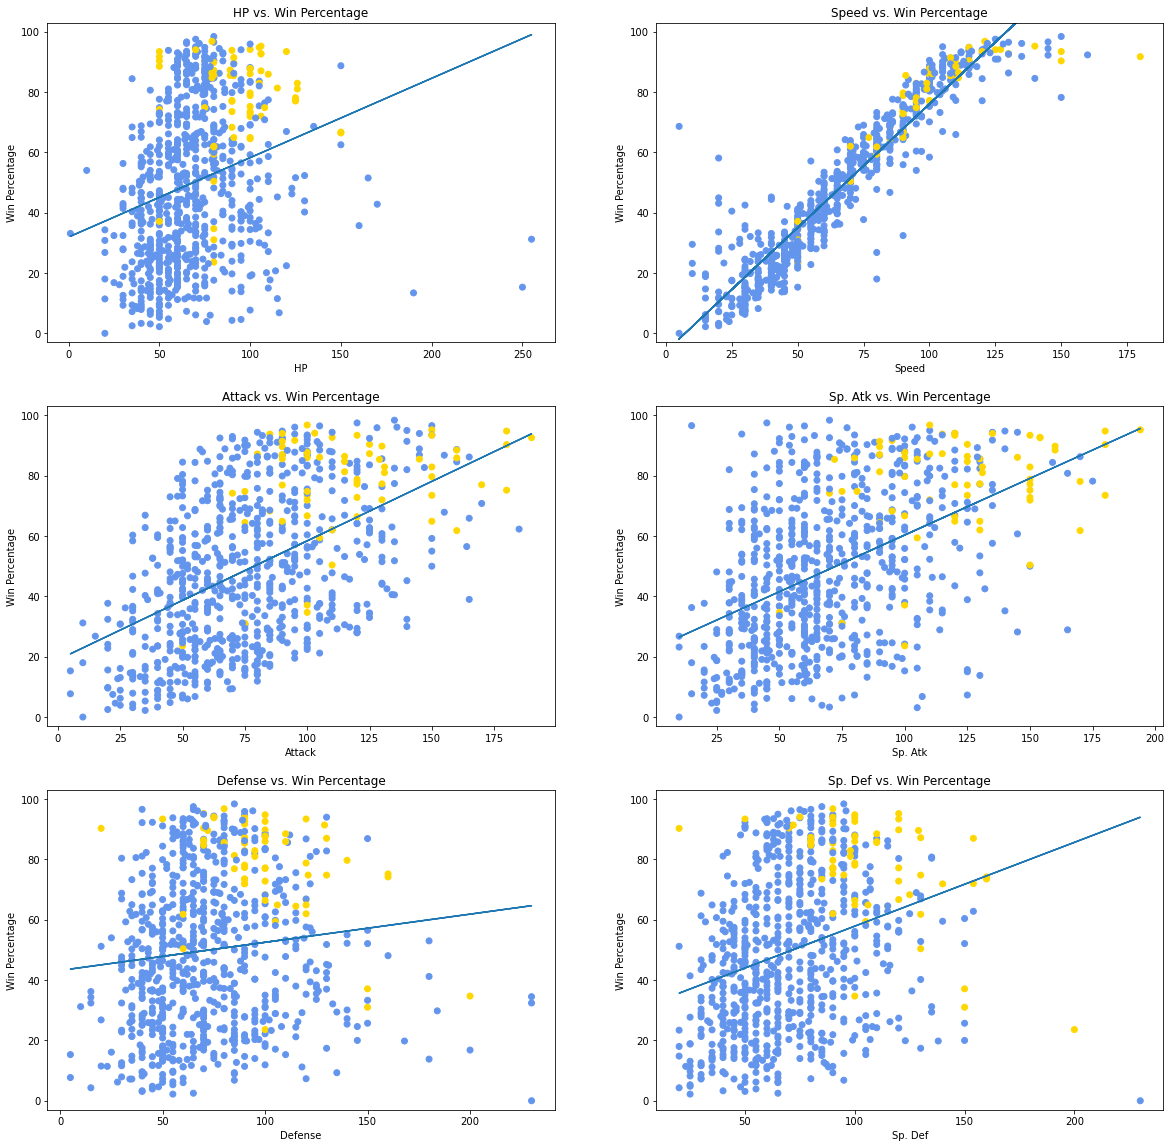

In [27]:
# Graph Base Stats -- Win Percentage
base_stats = ["HP", "Speed", "Attack", "Sp. Atk", "Defense", "Sp. Def"]
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
pts = [(i, j) for i in range(3) for j in range(2)]

color = np.where(pokemon['Legendary'] == True, 'gold', 'cornflowerblue')
for stat, (x,y) in zip(base_stats, pts):
  # Plot stat on subplot
  ax = axs[x, y]
  ax.scatter(stat, "win_pct", data=pokemon, c=color)
  ax.set(title=f'{stat} vs. Win Percentage', xlabel=stat, ylabel='Win Percentage')

  ax.set_ylim(-3,103)
  x,y= pokemon[stat], pokemon['win_pct']
  m,b = np.polyfit(x,y,1)
  ax.plot(x,m*x + b)

There is a lot going on here! Lets break down these graphs. First, there is a strong and obvious relationship between a Pokemon's speed and its win rate. The Speed Vs. Win graph has the steapest line. Attack and Sp. Attack can both be observed to have correlations but not as pronounced as Speed. The other graphs do not seem to have much going on.

A second thing to note is the positioning of most of the Legendary Pokemon. For the most part they are on the top half of each of the graphs. With a few extreme outliers, most of the legendary's are clustered together.

Let us graph the correlation between each of the stats and the win's to try and make a concrete observation.

<AxesSubplot:>

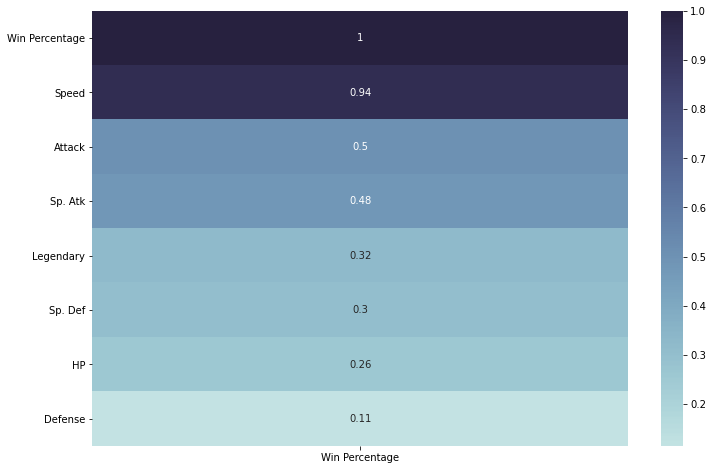

In [28]:
# Base stats, legendary status, win_pct
cols = list(pokemon.columns[4:10]) + ['Legendary', 'win_pct']
df = pokemon[cols].rename({'win_pct' : 'Win Percentage'}, axis=1)

# Setup graph
plt.figure(figsize=(12,8))
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

# Generate heatmap
data = df.corr()['Win Percentage'].sort_values(ascending=False)
sns.heatmap(pd.DataFrame(data), cmap=cmap, annot=True)

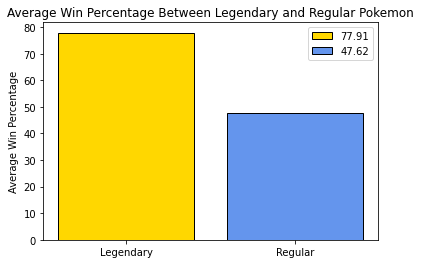

In [29]:
# Plot Average Win Percentage Legendary vs Regular
ax = plt.subplot()
res = pokemon.groupby(by="Legendary")['win_pct'].mean().round(2)
ax.bar('Legendary', res[1], color='gold', label=res[1], ec='black')
ax.bar('Regular', res[0], color='cornflowerblue', label=res[0], ec='black')
ax.set_title("Average Win Percentage Between Legendary and Regular Pokemon")
ax.set_ylabel("Average Win Percentage")
ax.legend()

These two graphs emphasize what we saw in our initial plots. The heatmap shows a strong correlation between Speed and wins, just like what we saw in the Speed vs Win graph. The Attack and Sp. Atk correlations is not as strong as we would have thought just by looking at the original graphs. They are higher then the other stats, which we did observe. 

The bar graph above shows, with conclusion that Pokemon deamed Legendary have a higher Average Win Percentage then regular Pokemon. We observed from the original plots that Legendary Pokemon seemed to be on the upper half of each plot. This concludes that Legendary Pokemon do have an average win percentage of just under 80%

Lastly, let us see if we can conclude anything about the types of Pokemon and their win rate. We noticed there was a difference in our initial analysis. We can graph a heatmap to try and spot the differences.

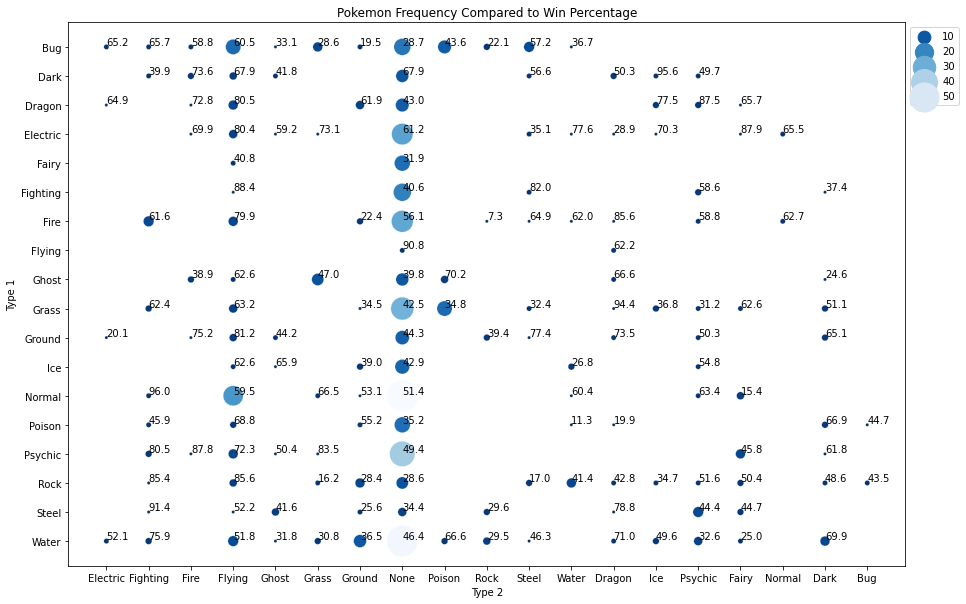

In [30]:
pokemon_copy = pokemon
pokemon_copy = pokemon_copy.fillna("None")
res = pokemon_copy.groupby(by=["Type 1", "Type 2"], dropna=False)['win_pct'].mean().round(1)
res = pd.DataFrame(res.reset_index())

plt.figure(figsize=(15,10))
plt.title('Pokemon Frequency Compared to Win Percentage')
count = pokemon_copy.groupby(['Type 1', 'Type 2']).size()
new_pokemon = count.to_frame(name='freq').reset_index()

ax = sns.scatterplot(x='Type 2', y='Type 1', data=res, hue='win_pct', size='win_pct', sizes=(1,5), legend=False)
sns.scatterplot(x='Type 2', y='Type 1', data=new_pokemon, hue='freq', size='freq', sizes=(10, 1000), palette='Blues_r', legend='brief')

for line in range(0, res.shape[0]):
  ax.text(res['Type 2'][line], res['Type 1'][line], res['win_pct'][line], horizontalalignment='left', verticalalignment='bottom', size='medium', color='black')

plt.xticks()
plt.legend(bbox_to_anchor=(1,1), loc=2)

It might be hard to conclude anything from this graph. There are definietly some outliers. For example, Dark-Ice has a 96% win rate, but relatively small frequency. This graph also shows the dominate pairings. A lot of types seem to have Flying for its type 2, which seems to have relatively high win rates. Fighting as a second type also seems to have an edge. We as humans might not be able to find any concrete patterns here. This is where machine learning will come in. Are Pokemon stats in combination with their types a glorified game of rock-paper-scissors? Lets find out by training some models.

## Machine Learning

<p>
While we have tidied up our data from visualization and exploration. It is by no means ready for a machine learning model. We have to create our own custom dataset.

We want to create a feature set of the two Pokemons stats and types for each of the battles. This will allow us to train different regression models where the output is either a 0 or 1. 0 will mean the first Pokemon won,and a 1 will mean the second Pokemon won. 

First We will finalize our feature set, which will be denoted "pokemon_ml," and to make sure there are no NaN values. 
</p>

In [31]:
pokemon_ml = pokemon.drop(["Name","Generation", "Wins", "Loss", "win_loss", "win_pct"], axis=1)
pokemon_ml.set_index("#", inplace=True)
pokemon_ml["Type 2"].fillna("None", inplace=True)
pokemon_ml.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
#,,,,,,,,,
1,Grass,Poison,45,49,49,65,65,45,False
2,Grass,Poison,60,62,63,80,80,60,False
3,Grass,Poison,80,82,83,100,100,80,False
4,Grass,Poison,80,100,123,122,120,80,False
5,Fire,None,39,52,43,60,50,65,False


### Creating the Feature Set

This is a great start to our ML dataset. We have isolated the features we want to train our model on. Our next step is to encode the types and legendary status. 

ML models would not understand the word "grass" so we are going to use an Ordinal Encoder to convert the types into a range from 0 to 17. Sklearn has a package that does just that. 

In [32]:
from sklearn.preprocessing import OrdinalEncoder

pokemon_cat = pokemon_ml[["Type 1", "Type 2", "Legendary"]]
ordinal_encoder = OrdinalEncoder()
pokemon_cat_encoded = ordinal_encoder.fit_transform(pokemon_cat)

print(pokemon_cat_encoded[:5]) 
print(ordinal_encoder.categories_)

[[ 9. 14.  0.]
 [ 9. 14.  0.]
 [ 9. 14.  0.]
 [ 9. 14.  0.]
 [ 6. 12.  0.]]
[array(['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
       'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
       'Psychic', 'Rock', 'Steel', 'Water'], dtype=object), array(['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
       'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'None', 'Normal',
       'Poison', 'Psychic', 'Rock', 'Steel', 'Water'], dtype=object), array([False,  True])]


In [33]:
#This will finalize the data for ml
pokemon_cat_encoded = pd.DataFrame(pokemon_cat_encoded, columns=["Type 1", "Type 2", "Legendary"])
pokemon_cat_encoded.index = pokemon_ml.index 
pokemon_ml["Type 1"] = pokemon_cat_encoded["Type 1"]
pokemon_ml["Type 2"] = pokemon_cat_encoded["Type 2"]
pokemon_ml["Legendary"] = pokemon_cat_encoded["Legendary"]
pokemon_ml.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
#,,,,,,,,,
1,9.0,14.0,45,49,49,65,65,45,0.0
2,9.0,14.0,60,62,63,80,80,60,0.0
3,9.0,14.0,80,82,83,100,100,80,0.0
4,9.0,14.0,80,100,123,122,120,80,0.0
5,6.0,12.0,39,52,43,60,50,65,0.0


In [34]:
pokemon_ml.isna().sum()

Type 1       0
Type 2       0
HP           0
Attack       0
Defense      0
Sp. Atk      0
Sp. Def      0
Speed        0
Legendary    0
dtype: int64

Great! Our pokemon_ml feature set is ready to go! There are no NaN anywhere to be found and we have encoded our data efficiently. We now have to do a self join between the numbers given in the combats dataset to create our final feature set that can be used with ML models.

In [35]:
#First we will clean up combats and get just the features we need
df = combats.drop('Loser', axis=1)
df.columns = ['1', '2', 'Winner']

# X will be the final feature set. Doing a self join on the first and second Pokemon.
X = df.join(pokemon_ml, on='1').join(pokemon_ml, on='2', lsuffix=" P1", rsuffix=" P2")
X = X.drop(["1", "2"], axis=1).reset_index(drop=True)
y = X.pop('Winner')
display("Features: ", X.head())

'Features: '

,Type 1 P1,Type 2 P1,HP P1,Attack P1,Defense P1,Sp. Atk P1,Sp. Def P1,Speed P1,Legendary P1,Type 1 P2,Type 2 P2,HP P2,Attack P2,Defense P2,Sp. Atk P2,Sp. Def P2,Speed P2,Legendary P2
0,15.0,10.0,50,64,50,45,50,41,0.0,9.0,1.0,70,70,40,60,40,60,0.0
1,9.0,5.0,91,90,72,90,129,108,1.0,15.0,5.0,91,129,90,72,90,108,1.0
2,4.0,7.0,55,40,85,80,105,40,0.0,14.0,12.0,75,75,75,125,95,40,0.0
3,6.0,12.0,40,40,40,70,40,20,0.0,2.0,12.0,77,120,90,60,90,48,0.0
4,15.0,18.0,70,60,125,115,70,55,0.0,0.0,16.0,20,10,230,10,230,5,0.0


In [37]:
#y is our labels. Either a 0 or a 1
df['y'] = (df['2'] == df["Winner"]).astype(int)
y = df['y'].copy()
display("Final y:", y.head())

'Final y:'

0    1
1    1
2    1
3    1
4    0
Name: y, dtype: int32

### Training Models

Our feature set is ready to go. We have about 20 features that will be passed into each model which will then output a 0 or 1. We will use sklearns train_test_split method to creatue our training and testing data. 

We will train a variety of models to explore which ones will produce the most accurate results. To start, linear regression will be used as a bass line. Since our data is meant for logistical regression, this should produce poor results. We will use KNN, decision tree and logistical regression to try and beat the results from linear regression.

In [38]:
#Split daat 80:20
from sklearn.model_selection import train_test_split

x_train, x_test , y_train, y_test= train_test_split(X, y, test_size = 0.2)

In [45]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
acc_lin= lin_reg.score(x_test, y_test)
print("Linear Regression accuracy:", acc_lin)

Linear Regression accuracy: 0.4714322096355098


As expected linear regression had a low accuracy of 47% predicting which pokemon would win in a battle. Lets try out some models that should do a lot better!

In [46]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
acc_log= log_reg.score(x_test, y_test)
print("Logistic Regression Accuracy: ", acc_log)

Logistic Regression Accuracy:  0.8893


Great! Logistic Regression did much better! With an accuracy of about 89% this can predict the outcome of two pokemon in battle. It seems pretty good, lets try out a few more models to see if we can do better.

In [48]:
from sklearn.neighbors import KNeighborsClassifier

for k in range(3, 10, 2):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    acc_knn = knn.score(x_test, y_test)
    print("KNN with k=", k, "Accuracy: ", acc_knn)

KNN with k= 3 Accuracy:  0.867
KNN with k= 5 Accuracy:  0.8748
KNN with k= 7 Accuracy:  0.8779
KNN with k= 9 Accuracy:  0.8781


In [ ]:
It seems KNN maxes out around 87% accuracy above k=3. We could use any K here since there is not much difference. 

In [49]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(x_train, y_train)
acc_tree = tree_reg.score(x_test, y_test)
print("Decision Tree Regressor Accuracy: ", acc_tree)

Decision Tree Regressor Accuracy:  0.712242902258773


Woah, this is not the direction we wanted to go in! We can stick with Logistical Regression and KNN for now.

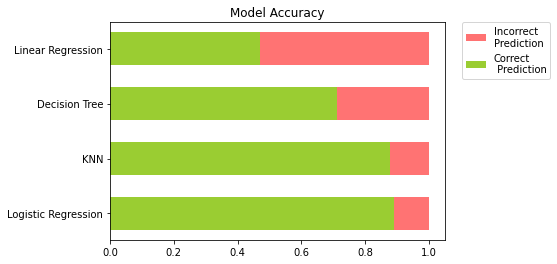

In [51]:
h = 0.6
c = 'red'

plt.barh(['Logistic Regression'], 1, color = c, alpha = 0.55, height = h)
plt.barh(['Logistic Regression'], acc_log, color = 'yellowgreen', alpha = 1, height = h)

plt.barh(['KNN'], 1, color = c, alpha = 0.55, height = h)
plt.barh(['KNN'], acc_knn, color = 'yellowgreen', alpha = 1, height = h)

plt.barh(['Decision Tree'], 1, color = c, alpha = 0.55, height = h)
plt.barh(['Decision Tree'], acc_tree, color = 'yellowgreen', alpha = 1, height = h)

plt.barh(['Linear Regression'], 1, color = c, alpha = 0.55, height = h)
plt.barh(['Linear Regression'], acc_lin, color = 'yellowgreen', alpha = 1, height = h)

plt.title("Model Accuracy")
plt.legend(['Incorrect\nPrediction', 'Correct\n Prediction'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Results

<p>
Well it seems we could not get a model above 89% accuracy, which is a shame. Logistic Regression and K Nearest Neighbors are the best models we trained to predict the outcome of a battle between two pokemon. There seems to have been enough of a relationship between specific stats and type for the models to see a pattern and accuratly make a guess as to which pokemon won.
</p>


## Conclusion

After we created our unique feature set, we were able to train a model with 89% accuracy on which Pokemon would win in a one versus one battle. While this is not the best accuracy, and we were hoping for higher, this is a good start. We would need to do an in-depth parameter tuning to get a better model. I am sure that if we got our hands on one of the new apple chips currently in development, we could do it in an instant. For now we will take what we can get. 

Thank you for following along with our data science tutorial!